<a href="https://colab.research.google.com/github/NivedithaVelaga/product-recommendation-system/blob/main/rank_based_product_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-commerce Product recommendation System

##Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

## Importing Dataset

In [2]:
#Import the data set
df = pd.read_csv('/content/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

In [3]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  335100
No of columns =  3


### Datatypes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335100 entries, 0 to 335099
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  335100 non-null  object 
 1   prod_id  335099 non-null  object 
 2   rating   335099 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.7+ MB


### Missing value analysis

In [6]:
# Find number of missing values in each column
df.isna().sum()

,0
user_id,0
prod_id,1
rating,1


### Summary

In [7]:
# Summary statistics of 'rating' variable
df['rating'].describe()

,rating
count,335099.000000
mean,3.995950
std,1.385577
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


### Rating distribution

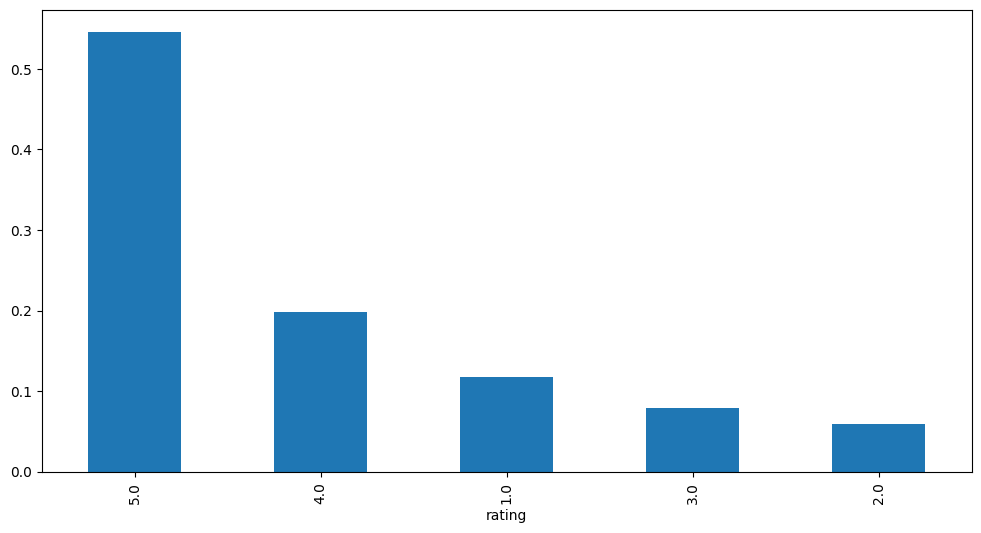

In [8]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [9]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  278824
Number of unique ITEMS in Raw data =  21173


### Users with most no of rating

In [10]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

,0
user_id,
A231WM2Z2JL0U3,239
A5JLAU2ARJ0BO,195
A25HBO5V8S8SEA,123
AKT8TGIT6VVZ5,73
A2AEZQ3DGBBLPR,68
A6FIAB28IS79,63
A11D1KHM7DVOQK,59
AT2J7H5TRZM8Z,57
A1MJMYLRTZ76ZX,56


## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [11]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [12]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 1147
Number of unique USERS in the final data =  13
Number of unique PRODUCTS in the final data =  1005


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [13]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (13, 1005)
given_num_of_ratings =  1147
possible_num_of_ratings =  13065
density: 8.78%


prod_id,1400532655,B000000O48,B000001OMN,B00000J05A,B00000J1E6,B00000J1G6,B00000J1TX,B00000J1UQ,B00000J1US,B00000J1UU,...,B0000BZZG1,B0000BZZG9,B0000BZZGB,B0000BZZGE,B0000C1ZHO,B0000C20XC,B0000C2W57,B0000C3GWV,B0000C3WBD,B0000C4DX5
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
A25HBO5V8S8SEA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Rank Based Recommendation System

In [5]:
import pandas as pd

# 1. RE-LOAD THE DATASET
# Replace 'ratings_Electronics.csv' with the ACTUAL name of your file in the Files tab
try:
    # We name the columns explicitly because Amazon datasets usually lack headers
    df = pd.read_csv('/content/ratings_Electronics.csv', names=['user_id', 'prod_id', 'rating', 'timestamp'])
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("ERROR: File not found! Please upload your CSV file to the Files tab on the left.")

# 2. RE-CREATE 'df_final' (Filter users with < 5 ratings)
# This prevents the 'Empty Matrix' errors you saw earlier
if 'df' in locals():
    counts = df['user_id'].value_counts()
    df_final = df[df['user_id'].isin(counts[counts >= 5].index)]
    print(f"df_final created with {len(df_final)} rows.")

    # 3. CALCULATE RATINGS (The part that was failing)
    average_rating = df_final.groupby('prod_id')['rating'].mean()
    count_rating = df_final.groupby('prod_id')['rating'].count()

    final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})
    final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

    print("\nTop 5 Products:")
    display(final_rating.head())

Dataset loaded successfully!
df_final created with 40882 rows.

Top 5 Products:


,avg_rating,rating_count
prod_id,,
1400699169,5.0,1
B0006HVY52,5.0,1
B0006HVUMY,5.0,1
B0006HVKM4,5.0,2
B0006HVIGC,5.0,2


In [6]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

## Recommending top 5 products with 50 minimum interactions based on popularity

In [7]:
list(top_n_products(final_rating, 5, 50))

['B0000BZL1P', 'B000053HH5', 'B00009R6WO', 'B00009R6WT', 'B00003G1RG']

## Recommending top 5 products with 100 minimum interactions based on popularity

In [8]:
list(top_n_products(final_rating, 5, 100))

['B0000BZL1P', 'B00017LSPI', 'B00009XVCZ', 'B0002L5R78', 'B00007E7JU']